Original shape: (20, 97)
Filtered shape: (20, 33)
Long format shape: (640, 3)

First few rows:
   epoch                                type        value
0    1.0            nudge 0.1 sigma  - _step  1294.483871
1    1.0  nudge 0.1 sigma  - class value (0)     0.100000
2    1.0  nudge 0.1 sigma  - class value (1)     0.100000
3    1.0  nudge 0.1 sigma  - class value (2)     0.080163
4    1.0  nudge 0.1 sigma  - class value (3)     0.092449
5    1.0  nudge 0.1 sigma  - class value (4)     0.100000
6    1.0  nudge 0.1 sigma  - class value (5)     0.085657
7    1.0  nudge 0.1 sigma  - class value (6)     0.094506
8    1.0  nudge 0.1 sigma  - class value (7)     0.092330
9    1.0  nudge 0.1 sigma  - class value (8)     0.084176

Unique types:
['nudge 0.1 sigma  - _step' 'nudge 0.1 sigma  - class value (0)'
 'nudge 0.1 sigma  - class value (1)' 'nudge 0.1 sigma  - class value (2)'
 'nudge 0.1 sigma  - class value (3)' 'nudge 0.1 sigma  - class value (4)'
 'nudge 0.1 sigma  - class value (5)'

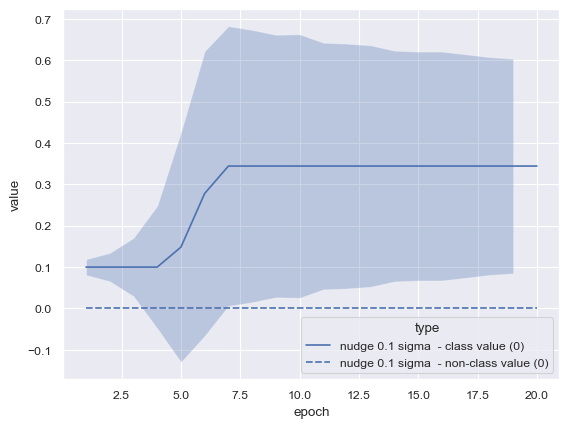

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("./data/class_values_nudge.csv")
df = df[(df["epoch"] != 1) & (df["epoch"] != 0)]
df["epoch"] = df["epoch"].apply(lambda x: np.floor(float(x)))
#print(df)


# Get only columns that don't end with __MIN or __MAX (plus epoch)
regular_cols = ['epoch'] + [col for col in df.columns if col != 'epoch' and not col.endswith('__MIN') and not col.endswith('__MAX')]
df_filtered = df[regular_cols]

# Reshape from wide to long format
df_long = pd.melt(df_filtered, 
                  id_vars=['epoch'], 
                  var_name='type', 
                  value_name='value')

# Optional: Clean up the 'type' column names if needed
# Remove common prefixes to make them more readable
#df_long['type'] = df_long['type'].str.replace('nudge 0.1 sigma - ', '', regex=False)
#df_long['type'] = df_long['type'].str.replace('nudge 0.1 base - ', '', regex=False)

# Sort by epoch and type for better readability
df_long = df_long.sort_values(['epoch', 'type']).reset_index(drop=True)

print(f"Original shape: {df.shape}")
print(f"Filtered shape: {df_filtered.shape}")
print(f"Long format shape: {df_long.shape}")
print("\nFirst few rows:")
print(df_long.head(10))
print("\nUnique types:")
print(df_long['type'].unique()[:10])  # Show first 10 types

sns.set_theme("paper")
sns.lineplot(data=df_long[(df_long["type"]=="nudge 0.1 sigma  - class value (0)") | (df_long["type"]=="nudge 0.1 sigma  - non-class value (0)")], x="epoch", y="value", style="type")

import matplotlib.pyplot as plt

# Add this after your existing sns.lineplot() call:

# Get the data for confidence intervals
class_value_data = df_long[df_long["type"] == "nudge 0.1 sigma  - class value (0)"].sort_values('epoch')
sigma_sum_data = df_long[df_long["type"] == "nudge 0.1 sigma  - sigma_sum(0)"].sort_values('epoch')

# Merge and calculate bounds
merged_data = pd.merge(class_value_data[['epoch', 'value']], 
                      sigma_sum_data[['epoch', 'value']], 
                      on='epoch', 
                      suffixes=('_class', '_sigma'))

merged_data['upper'] = merged_data['value_class'] + merged_data['value_sigma']
merged_data['lower'] = merged_data['value_class'] - merged_data['value_sigma']

# Add the error area
plt.fill_between(merged_data['epoch'], 
                merged_data['lower'], 
                merged_data['upper'], 
                alpha=0.3)

Area is sigma sum, when class and non-class are closer than sigma sum (around epoch 3 - 6) nc would get pushed down, but nc is at the lower bound so class value gets pushed up instead.

<Axes: xlabel='confidence', ylabel='hard accuracy'>

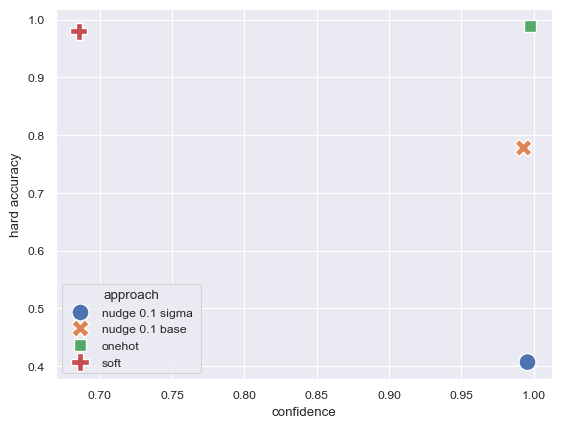

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

hvc = pd.read_csv("./data/accvconfidence.csv")

hvc = hvc.drop(columns=["_wandb"])
hvc.head()

#sns.set_style("white")
sns.set_theme("paper")
#sns.set_palette("colorblind")
hvc = hvc.rename(columns={"Name":"approach"})
sns.scatterplot(data=hvc, x="confidence", y="hard accuracy", style="approach", hue="approach", s=150)


Onehot is good because: Best overall accuracy
Soft is good because: Similar accuracy but lower confidence -> less likely to overfit

Our method: Very high confidence but lower acc -> doesn't have any real pros

<Axes: xlabel='epoch', ylabel='accuracy'>

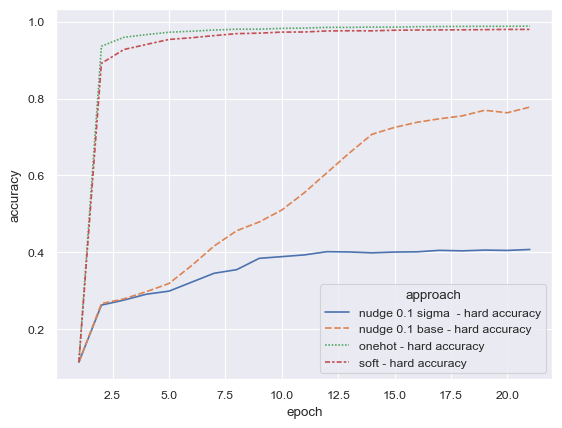

In [57]:
df_acc = pd.read_csv("./data/accuracy.csv")

# Get only columns that don't end with __MIN or __MAX (plus epoch)
def strip_maxmin(df):
    regular_cols = ['epoch'] + [col for col in df.columns if col != 'epoch' and not col.endswith('__MIN') and not col.endswith('__MAX') and not col.endswith('_step')]
    return df[regular_cols]

df_acc = strip_maxmin(df_acc)
df_acc.head()

df_acc = pd.melt(df_acc, id_vars=["epoch"], var_name="approach", value_name="accuracy")

sns.lineplot(data=df_acc, x="epoch", y="accuracy", style="approach", hue="approach")

<Axes: xlabel='epoch', ylabel='test loss'>

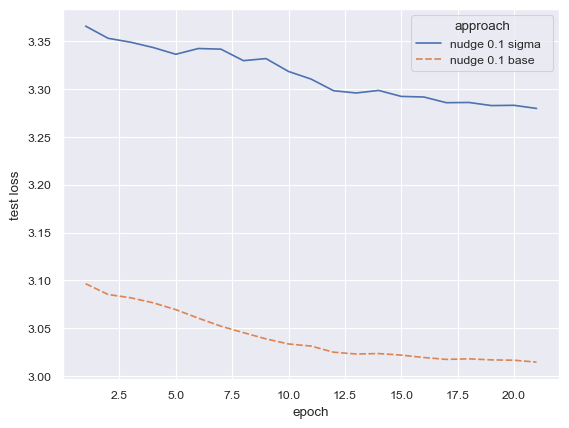

In [80]:
df = pd.read_csv("./data/loss.csv")

df = strip_maxmin(df)
df.head()

df = pd.melt(df, id_vars=["epoch"], var_name="approach", value_name="test loss")
df = df[df["approach"].str.contains("test")]

df["approach"] = df["approach"].str.replace("- test loss", "")

sns.lineplot(data=df[(df["approach"].str.contains("nudge"))], x="epoch", y="test loss", style="approach", hue="approach")
#df.head()

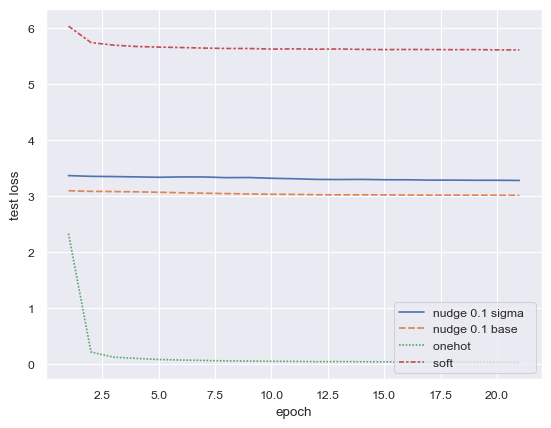

In [81]:
import matplotlib.pyplot as plt
df.head()
sns.lineplot(data=df, x="epoch", y="test loss", style="approach", hue="approach")
plt.legend(loc="lower right")

<Axes: xlabel='epoch', ylabel='accuracy/separation'>

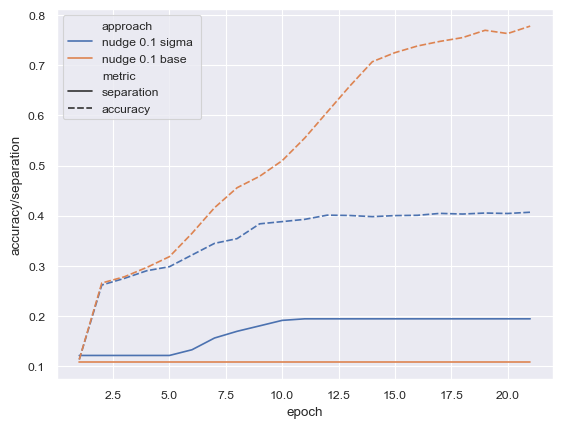

In [ ]:
df = pd.read_csv("./data/accvsep.csv")
df = strip_maxmin(df)

df = pd.melt(df, id_vars=["epoch"], var_name="type", value_name="accuracy/separation")
df[["approach", "metric_full"]] = df["type"].str.split(" - ", expand=True)
df["metric"] = df["metric_full"].str.replace("avg_", "")
df["metric"] = df["metric"].str.replace("hard ", "")

df = df.drop(columns=["type", "metric_full"])
df.head(100)
sns.lineplot(data=df, x="epoch", y="accuracy/separation", style="metric", hue="approach")